In [1]:
from plot_metric.functions import BinaryClassification
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import warnings
from sklearn.model_selection import GridSearchCV, train_test_split
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.svm import SVC 
from sklearn.metrics import make_scorer, recall_score,precision_score, confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data= pd.read_csv('../z_norm.csv')

### split data en X et Y

In [3]:
data1= data.copy()
X= data1.drop('Loan Status', axis=1)
Y= data1['Loan Status']

In [4]:
X_train , X_test , Y_train , Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 123)


In [5]:
np.unique(Y_train, return_counts=True)

(array([0, 1]), array([35917, 35869]))

### ---SVM---

In [6]:
params = {'C': [0.1, 1, 10, 100],  
          'gamma': [1, 0.1, 0.01, 0.001]}  
##accuracy
grid_search_acc= GridSearchCV(estimator=SVC(probability=True), param_grid= params, scoring='accuracy',cv=5, n_jobs=-1)
grid_search_acc= grid_search_acc.fit(X_train, Y_train)
y_predict= grid_search_acc.best_estimator_.predict(X_test)

----------
best parameters:  {'gamma': 0.1, 'C': 100}
----------
[[11407  3952]
 [ 1147 14260]]
----------
              precision    recall  f1-score   support

           0       0.91      0.74      0.82     15359
           1       0.78      0.93      0.85     15407

    accuracy                           0.83     30766
   macro avg       0.85      0.83      0.83     30766
weighted avg       0.85      0.83      0.83     30766

----------


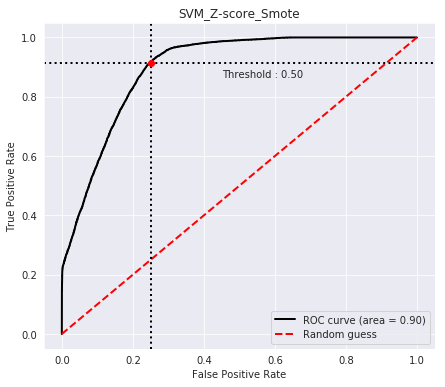

In [7]:
## evaluating the model
print("----------")
print('best parameters: ', grid_search_acc.best_params_)
print("----------")
print(confusion_matrix(Y_test,y_predict))
print("----------")
print(classification_report(Y_test, y_predict))
print("----------")


##ROC
y_predict_proba = grid_search_acc.best_estimator_.predict_proba(X_test)[:,1]

# Visualisation with plot_metric
bc = BinaryClassification(Y_test, y_predict_proba, labels=[1, 0])
# Figures
plt.figure(figsize=(7,6))
bc.plot_roc_curve()
plt.title('ROC curve')
plt.show()

In [8]:
## Recall
rec_avg=make_scorer(recall_score, average='macro')
grid_search_rec= GridSearchCV(estimator=SVC(probability=True), param_grid= params, scoring=rec_avg,cv=5, n_jobs=-1)
grid_search_rec= grid_search_rec.fit(X_train, Y_train)
y_predict= grid_search_rec.best_estimator_.predict(X_test)

In [9]:
## evaluating the model
print("----------")
print('best parameters: ', grid_search_rec.best_params_)
print("----------")
print(confusion_matrix(Y_test,y_predict))
print("----------")
print(classification_report(Y_test, y_predict))
print("----------")

----------
best parameters:  {'gamma': 0.1, 'C': 100}
----------
[[11407  3952]
 [ 1147 14260]]
----------
              precision    recall  f1-score   support

           0       0.91      0.74      0.82     15359
           1       0.78      0.93      0.85     15407

    accuracy                           0.83     30766
   macro avg       0.85      0.83      0.83     30766
weighted avg       0.85      0.83      0.83     30766

----------


In [10]:
## precision
prec_avg=make_scorer(precision_score, average='macro')
grid_search_prec_avg= GridSearchCV(estimator=SVC(probability=True), param_grid= params, scoring=prec_avg,cv=5, n_jobs=-1)
grid_search_prec_avg= grid_search_prec_avg.fit(X_train, Y_train)
y_predict= grid_search_prec_avg.best_estimator_.predict(X_test)

In [11]:
## evaluating the model
print("----------")
print('best parameters: ', grid_search_prec_avg.best_params_)
print("----------")
print(confusion_matrix(Y_test,y_predict))
print("----------")
print(classification_report(Y_test, y_predict))
print("----------")

----------
best parameters:  {'gamma': 0.01, 'C': 0.1}
----------
[[10922  4437]
 [  826 14581]]
----------
              precision    recall  f1-score   support

           0       0.93      0.71      0.81     15359
           1       0.77      0.95      0.85     15407

    accuracy                           0.83     30766
   macro avg       0.85      0.83      0.83     30766
weighted avg       0.85      0.83      0.83     30766

----------


In [12]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, titre):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        #ax.set_ylim([0.70,0.86])
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title(titre, fontsize=18, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=14)
    ax.set_ylabel(titre+'[CV Avg Score]', fontsize=14)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

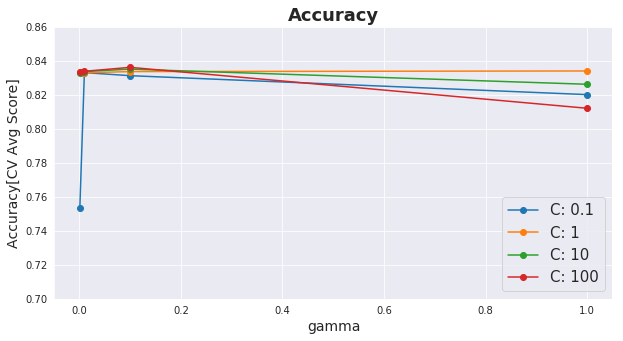

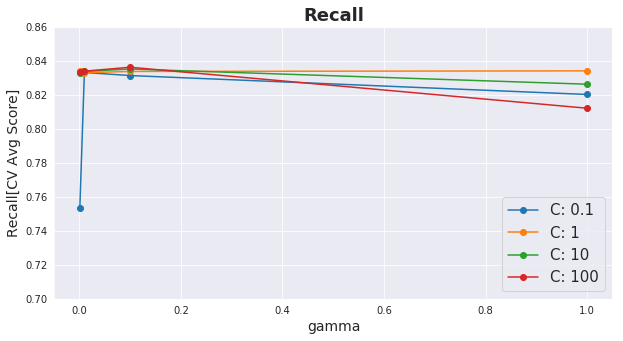

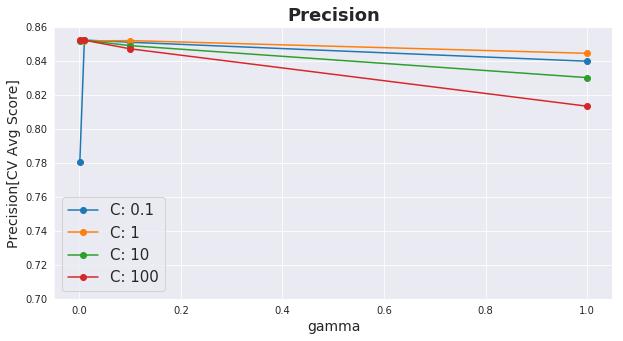

In [13]:
# Calling Method 
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plot_grid_search(grid_search_acc.cv_results_, params['gamma'], params['C'], 'gamma', 'C',  'Accuracy')
plot_grid_search(grid_search_rec.cv_results_, params['gamma'], params['C'], 'gamma', 'C', 'Recall')
plot_grid_search(grid_search_prec_avg.cv_results_, params['gamma'], params['C'], 'gamma', 'C', 'Precision')

In [14]:
def return_index_list(param1, param2):
    list=[]
    for p1 in param1:
        for p2 in param2:
            list.append('['+str(p1)+', '+str(p2)+']')
    return list
index= return_index_list(params['C'], params['gamma'])

In [17]:
df= pd.DataFrame({  'Accuracy': grid_search_acc.cv_results_['mean_test_score'],
                    'Precision(Avg)': grid_search_prec_avg.cv_results_['mean_test_score'],
                    'Recall(Avg)': grid_search_rec.cv_results_['mean_test_score'],
                     'std_cross_validation': grid_search_acc.cv_results_['std_test_score']},
                 index=index)

## to excel
writer = pd.ExcelWriter('SVM.xlsx')
df.to_excel(writer, 'SVM')
writer.save()
writer.close()

In [18]:
df

,Accuracy,Precision(Avg),Recall(Avg),std_cross_validation
"[0.1, 1]",0.820202,0.839857,0.820282,0.002454
"[0.1, 0.1]",0.831346,0.851021,0.831425,0.002020
"[0.1, 0.01]",0.833143,0.852326,0.833221,0.002249
"[0.1, 0.001]",0.753169,0.780482,0.753273,0.003188
"[1, 1]",0.834118,0.844505,0.834176,0.003089
"[1, 0.1]",0.833756,0.852000,0.833832,0.002057
"[1, 0.01]",0.833032,0.851754,0.833109,0.002028
"[1, 0.001]",0.833742,0.852244,0.833819,0.002346
"[10, 1]",0.826289,0.830205,0.826325,0.002093
"[10, 0.1]",0.835205,0.849024,0.835271,0.002502


In [ ]:
grid_search_acc.cv_results_
